# Programming Exercise 6: Support Vector Machines

In [67]:
% matplotlib inline
from math import *
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.io import loadmat
from sklearn.svm import SVC


## 1. Support Vector Machines

### 1.1 Example Dataset 1

In [68]:
data1 = loadmat('machine-learning-ex6/ex6/ex6data1.mat')
globals().update(data1)
print(X.shape)
print(y.shape)


(51, 2)
(51, 1)


In [69]:
def plotData(X, y):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*np.hsplit(X[np.where(y == 1)[0]], 2), c='k', marker='+')
    ax.scatter(*np.hsplit(X[np.where(y == 0)[0]], 2), c='y', marker='o')
    return fig, ax


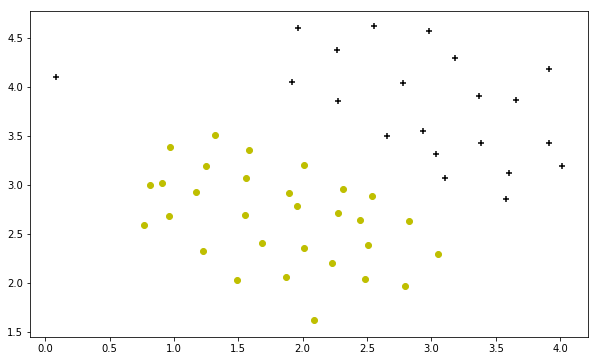

In [70]:
origin = plotData(X, y)


In [71]:
def visualizeBoundary(X, y, model):
    fig, ax = plotData(X, y)
    x1_min, x2_min = np.min(X, axis=0)
    x1_max, x2_max = np.max(X, axis=0)
    x1plot = np.linspace(x1_min, x1_max, 100)
    x2plot = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    Z = model.predict(np.column_stack((X1.ravel(), X2.ravel()))).reshape(X1.shape)
    ax.contour(x1plot, x2plot, Z, levels=[0], c="b")
    return fig, ax


In [72]:
def svmTrain(X, y, C, kernelFunction='linear', **kargs):
    clf = SVC(C=C, kernel=kernelFunction, **kargs)
    clf.fit(X, y.ravel())
    return clf


In [73]:
# C plays a role similar to 1/λ, where λ is the regularization parameter
def try_different_C(C):
    model = svmTrain(X, y, C)
    fig, ax = visualizeBoundary(X, y, model)
    ax.set_title(f"SVM Decision Boundary with C={C}")


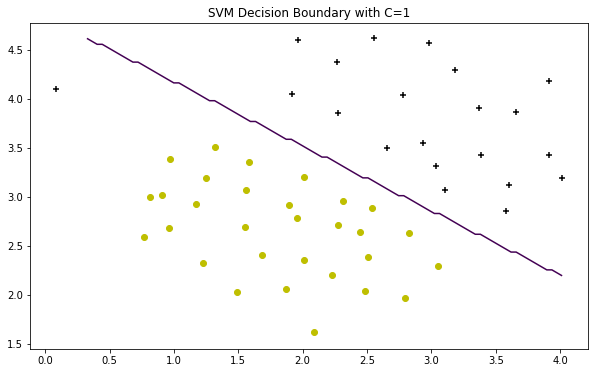

In [74]:
try_different_C(1)


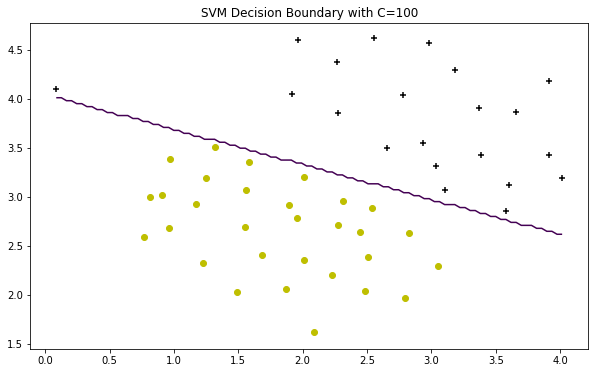

In [75]:
# SVM now classifies every single example correctly,
# but has a decision boundary that does not appear to be a natural fit for the data
try_different_C(100)


### 1.2 SVM with Gausssian Kernels

#### 1.2.1 Gaussian Kernel

 You can think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)},x^{(j)})$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

$$
K_{gaussian}(x^{(i)},x^{(j)}) = exp\bigg(- \frac{\lVert x^{(i)} - x^{(j)}\rVert^{2}}{2\sigma^{2}}\bigg) = exp\bigg(- \frac{\sum^{n}_{k=1}\big(x^{(i)}_{k} - x^{(j)}_{k}\big)^{2}}{2\sigma^{2}}\bigg)
$$

In [76]:
def gaussianKernel(x1, x2, sigma):
    norm = np.sum(np.square(x1 - x2))
    return exp(-norm / (2 * sigma ** 2))


In [77]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, - 1])
sigma = 2
sim = gaussianKernel(x1, x2, sigma)

np.testing.assert_approx_equal(sim, 0.324652, significant=6, err_msg="this value should be about 0.324652")
print(f"Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = {sigma} : {sim}")


Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2 : 0.32465246735834974


#### 1.2.2 Example Dataset 2

(<matplotlib.figure.Figure at 0x1c0f87fcd30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c0f8abb0f0>)

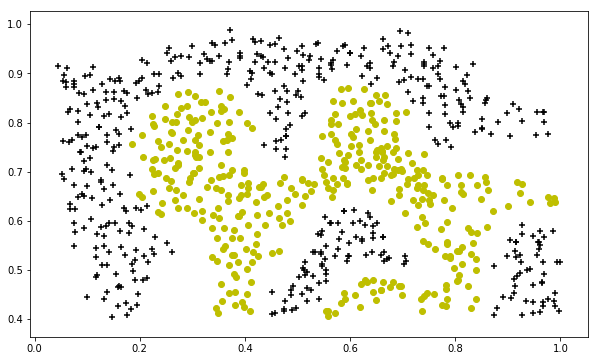

In [78]:
data2 = loadmat('machine-learning-ex6/ex6/ex6data2.mat')
globals().update(data2)
plotData(X, y)


(<matplotlib.figure.Figure at 0x1c0f8ad1f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c0f8d709e8>)

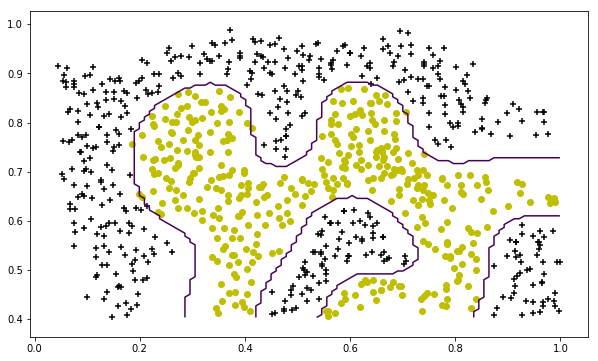

In [79]:
# gamma = 1/ (2 * sigma^2)
model = svmTrain(X, y, C=1, kernelFunction="rbf", gamma=pow(0.1, -2))
visualizeBoundary(X, y, model)


#### 1.2.3 Example Dataset 3

(<matplotlib.figure.Figure at 0x1c0f8ad0358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c0f8ad8c88>)

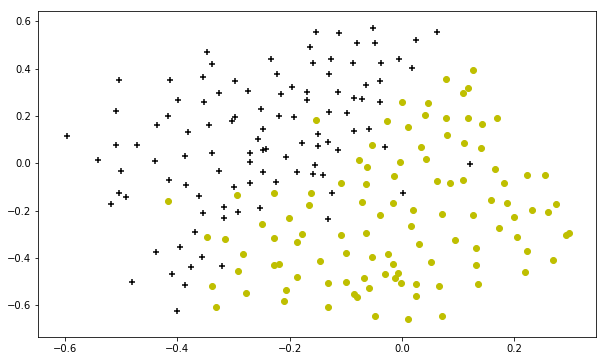

In [80]:
data3 = loadmat('machine-learning-ex6/ex6/ex6data3.mat')
globals().update(data3)
plotData(X, y)


In [81]:
def dataset3Params(X, y, Xval, yval):
    scores = []
    for C in np.logspace(-4, 3, 10, base=10 / 3):
        for sigma in np.logspace(-4, 3, 10, base=10 / 3):
            gamma = pow(sigma, -2) / 2
            model = svmTrain(X, y, C=C, kernelFunction="rbf", gamma=gamma)
            scores.append((model.score(Xval, yval), model.score(X, y), (C, sigma)))
    scores.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return scores[0][2]


(<matplotlib.figure.Figure at 0x1c0f8b02668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c0f89c52e8>)

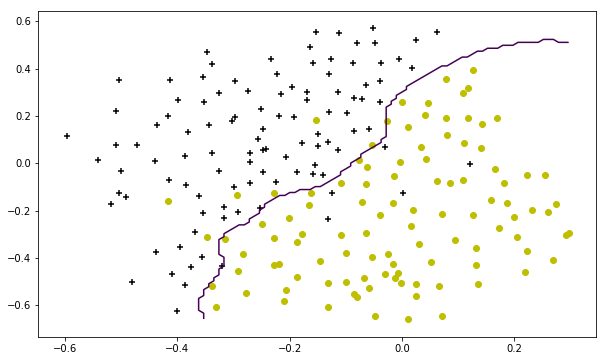

In [82]:
# Your task is to use the cross validation set Xval, yval 
# to determine the best C and σ parameter to use
C, sigma = dataset3Params(X, y, Xval, yval)

model = svmTrain(X, y, C=C, kernelFunction="rbf", gamma=pow(sigma, -2))
visualizeBoundary(X, y, model)


## 2 Spam Classification

### 2.1 Preprocessing Emails

In [92]:
def getVocabList():
    return np.loadtxt('./machine-learning-ex6/ex6/vocab.txt', dtype=str)[:, 1]


In [113]:
def processEmail(email: str):
    vol = getVocabList()
    email = email.lower()
    repleces = {
        ""         : re.compile("<[^<>]+>"),
        "number"   : re.compile("[0-9]+"),
        "httpaddr" : re.compile("(http|https)://[^\s]*"),
        "emailaddr": re.compile("[^\s]+@[^\s]+"),
        "dollar"   : re.compile("[$]+")
    }
    for replacement, pattern in repleces.items():
        email = re.sub(pattern, replacement, email)
    words = np.array(list(filter(lambda x: x, re.split("[\s\@\$\/\#.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]", email))))
    def find_index(word):
        max_len, final_index = 0, None
        for index, s in enumerate(vol):
            try:
                word.index(s)
                if len(s) > max_len:
                    max_len = len(s)
                    final_index = index
            except ValueError:
                continue
        return final_index

    return list(filter(lambda x: x, map(find_index, words)))


In [114]:
# Preprocessing sample email (emailSample1.txt)
# Extract Features
file_contents = open('./machine-learning-ex6/ex6/emailSample1.txt', "r").read()
print(file_contents)
# word_indices = processEmail(file_contents)


> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




### 2.1.1 Vocabulary List

In [118]:
word_indices = processEmail(file_contents)
